In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ["WANDB_API_KEY"] = "cd71d6f2249981dffae87be7baa57f08fe64c95e"
os.environ["WANDB_MODE"] = "online"
wandb.login()

wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(
    project="driver-drowsiness",
    name="mobilenetv2_transfer3",
    config={
        "img_size": 224,
        "batch_size": 32,
        "epochs": 30,
        "optimizer": "AdamW",
        "architecture": "MobileNetV2",
        "learning_rate": 1e-5,
        "weight_decay":1e-4,
        "loss": "binary_crossentropy",
    }
)

config = wandb.config


In [4]:
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25, 
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    "../data/train",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    "../data/val",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "../data/test",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)


Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


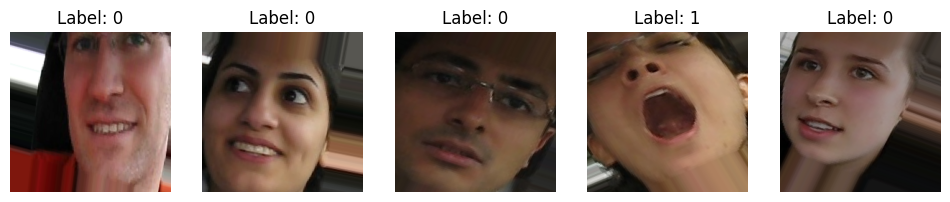

In [5]:
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):
    img = x_batch[i]

    # Reverse preprocess_input FOR VISUALIZATION ONLY
    img_vis = (img + 1.0) / 2.0        # [-1,1] -> [0,1]
    img_vis = np.clip(img_vis, 0, 1)

    axes[i].imshow(img_vis)
    axes[i].set_title(f"Label: {int(y_batch[i])}")
    axes[i].axis("off")

plt.show()


In [6]:
print(train_generator.class_indices)

{'normal': 0, 'yawn': 1}


In [7]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(config.img_size, config.img_size, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=AdamW(learning_rate=config.learning_rate,weight_decay=config.weight_decay),
    loss=config.loss,
    metrics=["accuracy",tf.keras.metrics.Recall(name="recall")]
)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,370,177 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

checkpoint = WandbModelCheckpoint(
    filepath="../models/mobilenet3/best.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
)

callbacks = [
    early_stop,
    checkpoint,
    reduce_lr,
    WandbMetricsLogger()
]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [11]:
weights = {0: 1.0, 1: 2.85}
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.epochs,
    class_weight=weights,
    callbacks=callbacks,
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5407 - loss: 3.5061 - recall: 0.4774 - val_accuracy: 0.6988 - val_loss: 2.9354 - val_recall: 0.6697 - learning_rate: 1.0000e-05
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5584 - loss: 3.3622 - recall: 0.6500 - val_accuracy: 0.7728 - val_loss: 2.8593 - val_recall: 0.6606 - learning_rate: 1.0000e-05
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6437 - loss: 3.2492 - recall: 0.7123 - val_accuracy: 0.8346 - val_loss: 2.7753 - val_recall: 0.5872 - learning_rate: 1.0000e-05
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6807 - loss: 3.1831 - recall: 0.7050 - val_accuracy: 0.8691 - val_loss: 2.7160 - val_recall: 0.6422 - learning_rate: 1.0000e-05
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6778 - loss: 3.1632 - recall: 0.6649 - val_accuracy: 0.8790 - val_loss: 2.6710 - val_recall: 0.6697 - learning_rate: 1.0000e-05
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━

In [12]:
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.3).astype(int).ravel()
y_true = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)   # THIS IS CRITICAL
f1 = f1_score(y_true, y_pred)
print(f"accuracy_score:{acc}\nprecision_score:{prec}\nrecall_score:{rec}\nf1_score:{f1}")

accuracy_score:0.8574938574938575
precision_score:0.7
recall_score:0.8272727272727273
f1_score:0.7583333333333333


In [14]:
wandb.log({
    "test_accuracy": acc,
    "test_precision": prec,
    "test_recall": rec,
    "test_f1": f1
})

In [15]:
class_names = list(test_generator.class_indices.keys())
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
)

print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      normal     0.9314    0.8687    0.8990       297
        yawn     0.7000    0.8273    0.7583       110

    accuracy                         0.8575       407
   macro avg     0.8157    0.8480    0.8286       407
weighted avg     0.8689    0.8575    0.8609       407



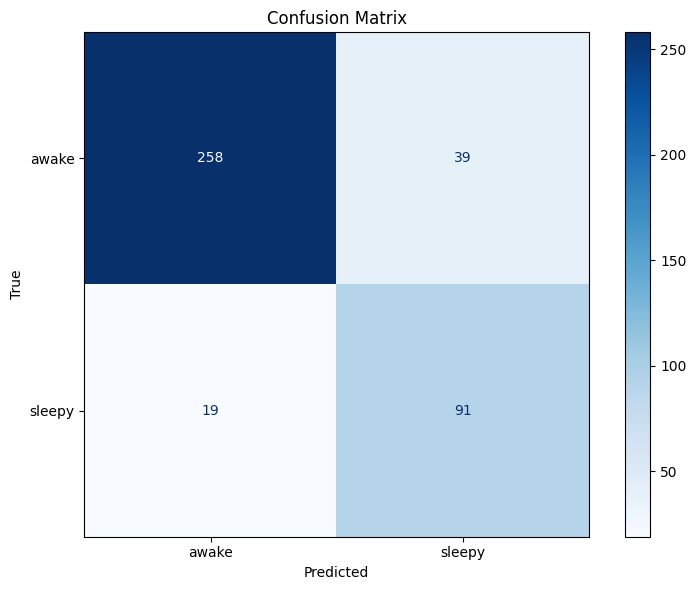

In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(cm, display_labels=['awake','sleepy'])
cmd.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
with open("../models/mobilenet3/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [18]:
wandb.finish()

epoch/accuracy,▁▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch/recall,▁▃▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇███▇▇████
epoch/val_accuracy,▁▃▅▆▇▇▇▇▇█████████████████████
epoch/val_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_recall,▄▃▁▃▄▂▃▅▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
test_accuracy,▁
test_f1,▁
+2,...
